# *Set up*

In [1]:
!pip install ndjson
!pip install cairocffi
!pip install imutils

     |████████████████████████████████| 71kB 4.3MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp37-none-any.whl size=89548 sha256=a2a0c0a4eecfd15998662469fa79e6df13830a8e70e8e3afb62d81ac915f23d8
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi


In [2]:
import os
import ndjson
import pandas as pd
import cairocffi as cairo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import imutils
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader
import random

In [3]:
category = ['apple','face'] # add training classes
batch_size = 32
image_size = 28
number_per_catogory = 5000
dataset_seed = 42
train_ratio = 0.6
validation_ratio = 0.2
all_samples = len(category)*number_per_catogory

np.random.seed(dataset_seed)
TRAIN_INDICES = random.sample(list(range(all_samples)), int(all_samples*train_ratio))
print(len(TRAIN_INDICES))
temp_INDICES = list(set(range(all_samples)) - set(TRAIN_INDICES))
print(len(temp_INDICES))
VAL_INDICES = random.sample(list(temp_INDICES), int(all_samples*validation_ratio))
TEST_INDICES = list(set(temp_INDICES) - set(VAL_INDICES))
print("total training samples:",len(TRAIN_INDICES))
print("total validatoin samples:",len(VAL_INDICES))
print("total test samples:",len(TEST_INDICES))

6000
4000
total training samples: 6000
total validatoin samples: 2000
total test samples: 2000


In [4]:
# download simplified data
!mkdir quickDrawData
for item in category:
  path=os.path.join('gs://quickdraw_dataset/full/simplified',item+'.ndjson')
  print(path)
  !gsutil -m cp $path ./quickDrawData/

gs://quickdraw_dataset/full/simplified/apple.ndjson
Copying gs://quickdraw_dataset/full/simplified/apple.ndjson...
- [1/1 files][ 56.1 MiB/ 56.1 MiB] 100% Done                                    
Operation completed over 1 objects/56.1 MiB.                                     
gs://quickdraw_dataset/full/simplified/face.ndjson
Copying gs://quickdraw_dataset/full/simplified/face.ndjson...
\ [1/1 files][ 89.4 MiB/ 89.4 MiB] 100% Done                                    
Operation completed over 1 objects/89.4 MiB.                                     


# *Helper functions*

In [6]:
# credit to:
#https://github.com/googlecreativelab/quickdraw-dataset/issues/19

def vector_to_raster(vector_images, side=28, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        
        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

In [7]:
def rotate_img(img):
  angle = np.random.randint(20, 160)  # chosen uniformly between -20 and +20.
  # Determine the centre
  height, width = img.shape[:2]
  cX, cY = (width // 2, height // 2)
  # Get the rotation matrix 
  M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
  cos = np.abs(M[0, 0])
  sin = np.abs(M[0, 1])
  # Compute the new bounding dimensions of the image
  nW = int((height * sin) + (width * cos))
  nH = int((height * cos) + (width * sin))
  # Adjust the rotation matrix
  M[0, 2] += (nW / 2) - cX
  M[1, 2] += (nH / 2) - cY
  # Perform the actual rotation
  img = cv2.warpAffine(img, M, (nW, nH))
  new_height, new_width = img.shape[:2]
  new_cX, new_cY = (new_width // 2, new_height // 2)
  crop_img = img[new_cY-20:new_cY+20, new_cX-20:new_cX+20]
  return crop_img

In [8]:
def shear_img(img):
  shear_factor = np.random.randint(10, 20)
  shear_factor /= 100
  height, width = img.shape[:2]
  M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
  nW =  img.shape[1] + abs(shear_factor*img.shape[0])
  img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
  img = cv2.resize(img, (width,height))
  return img

# *DrawDataset*

In [9]:
class DrawDataset(data.Dataset):
    def __init__(self, dataset_type, image_size, categories, number_per_catogory, transformation=None):
        all_images = []
        all_labels = []
        all_keys = []
        for item in categories:
          with open(os.path.join('quickDrawData',item+'.ndjson')) as f:
            print("adding from: ",item)
            data = ndjson.load(f)
            df=pd.DataFrame.from_dict(data)
            #new_df=df[df['countrycode']=='US']
            new_df=df[df['countrycode'].isin(['CA','US'])]
            new_df=new_df[new_df['recognized']==True]
            all_images+=(list(new_df['drawing'].values)[:number_per_catogory])
            all_labels+=(list(new_df['word'].values)[:number_per_catogory])
            all_keys+=(list(new_df['key_id'].values)[:number_per_catogory])
            

        arr=vector_to_raster(all_images,side=image_size)
        images = [x.reshape(image_size,image_size) for x in arr]

        all_labels=np.array(all_labels)
        images=np.array(images)
        all_keys=np.array(all_keys)

        if dataset_type=='test':
          # TO DO: ADD TRANSFORMATION FOR TEST SET according to the following link
          # https://www.cs.toronto.edu/~tijmen/affNIST/
          print("building test dataset")
          if transformation==None:
            all_labels=all_labels[TEST_INDICES]
            images=images[TEST_INDICES]
            all_keys=all_keys[TEST_INDICES]
            images=[np.pad(x, [(6, 6), (6, 6)], mode='constant', constant_values=0) for x in images]
          elif transformation=='rotate':
            all_labels=all_labels[TEST_INDICES]
            images=[np.pad(x, [(26, 26), (26, 26)], mode='constant', constant_values=0) for x in images[TEST_INDICES]]
            images = [rotate_img(img) for img in images]
            #images=list(map(rotate_img, images[TEST_INDICES]))
            all_keys=all_keys[TEST_INDICES]
          elif transformation=='shear':
            all_labels=all_labels[TEST_INDICES]
            images = [shear_img(img) for img in images[TEST_INDICES]]
            all_keys=all_keys[TEST_INDICES]
            images=[np.pad(x, [(6, 6), (6, 6)], mode='constant', constant_values=0) for x in images]
        elif dataset_type=='train':
          print("building ",dataset_type, " dataset")
          all_labels=all_labels[TRAIN_INDICES]
          images=images[TRAIN_INDICES]
          all_keys=all_keys[TRAIN_INDICES]
          images=[np.pad(x, [(6, 6), (6, 6)], mode='constant', constant_values=0) for x in images]
        else:
          print("building ",dataset_type, " dataset")
          all_labels=all_labels[VAL_INDICES]
          images=images[VAL_INDICES]
          all_keys=all_keys[VAL_INDICES]
          images=[np.pad(x, [(6, 6), (6, 6)], mode='constant', constant_values=0) for x in images]


        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(all_labels)
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        
        self.X = images
        self.y = onehot_encoded
        self.labels = all_labels
        self.keys = all_keys
        # normalize

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index],self.y[index]

In [10]:
train_dataset=DrawDataset('train', image_size, category, number_per_catogory)
val_dataset=DrawDataset('val', image_size, category, number_per_catogory)
test_dataset=DrawDataset('test', image_size, category, number_per_catogory)

adding from:  apple
adding from:  face
building  train  dataset
adding from:  apple
adding from:  face
building  val  dataset
adding from:  apple
adding from:  face
building test dataset


In [11]:
test_dataset_with_rotation=DrawDataset('test', image_size, category, number_per_catogory, transformation='rotate')
test_dataset_with_shearing=DrawDataset('test', image_size, category, number_per_catogory, transformation='shear')

adding from:  apple
adding from:  face
building test dataset
adding from:  apple
adding from:  face
building test dataset


# *Check the results (delete it later...)*

2000
2000


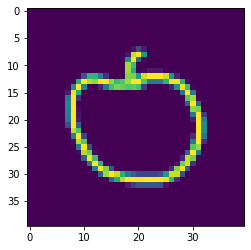

[1. 0.]
apple


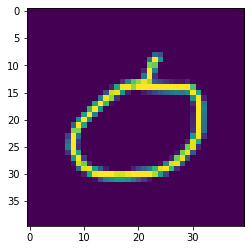

[1. 0.]
apple


In [14]:
# Check without transformation--------
# total # of training examples
print(len(test_dataset))
print(len(test_dataset.labels))
# Apple
img1 = test_dataset[2][0]
plt.imshow(img1)
plt.show()
print(test_dataset[2][1])
print(test_dataset.labels[2])
# Face
img2 = test_dataset[1000][0]
plt.imshow(img2)
plt.show()
print(test_dataset[1000][1])
print(test_dataset.labels[1000])

2000
2000


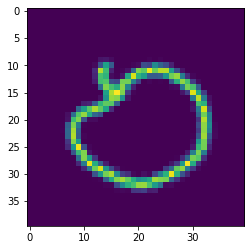

[1. 0.]
apple


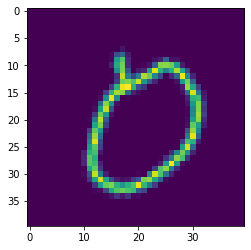

[1. 0.]
apple


In [13]:
# Check with transformation--------
# total # of training examples
print(len(test_dataset_with_rotation))
print(len(test_dataset_with_rotation.labels))
# Apple
img1 = test_dataset_with_rotation[2][0]
plt.imshow(img1)
plt.show()
print(test_dataset_with_rotation[2][1])
print(test_dataset_with_rotation.labels[2])
# Face
img2 = test_dataset_with_rotation[1000][0]
plt.imshow(img2)
plt.show()
print(test_dataset_with_rotation[1000][1])
print(test_dataset_with_rotation.labels[1000])

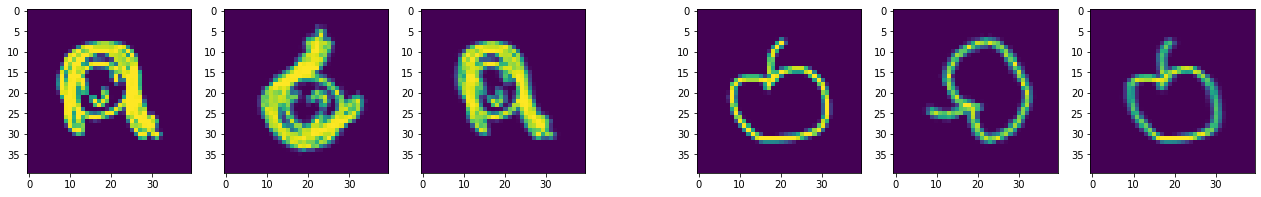

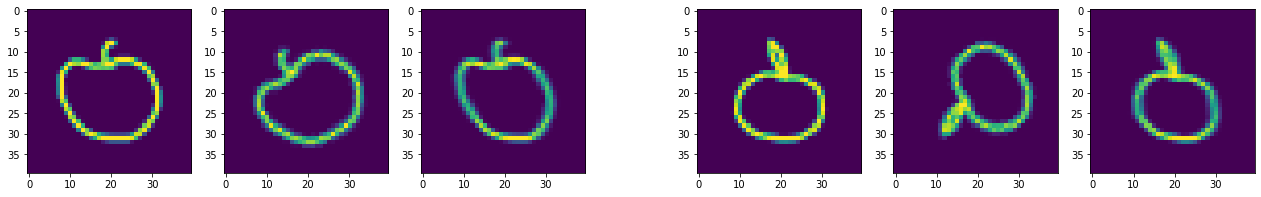

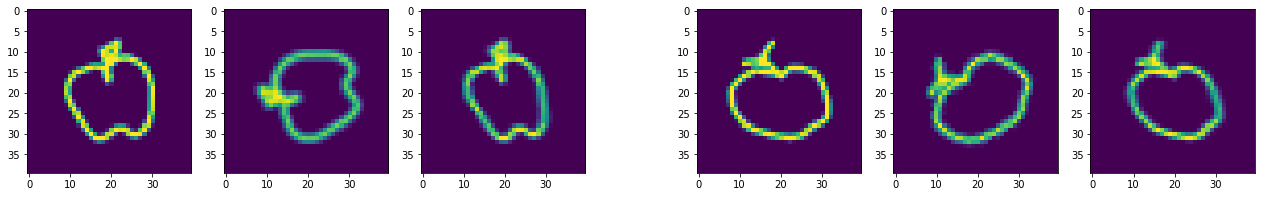

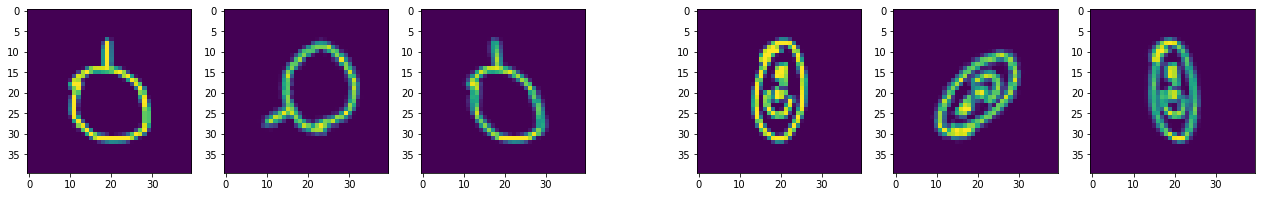

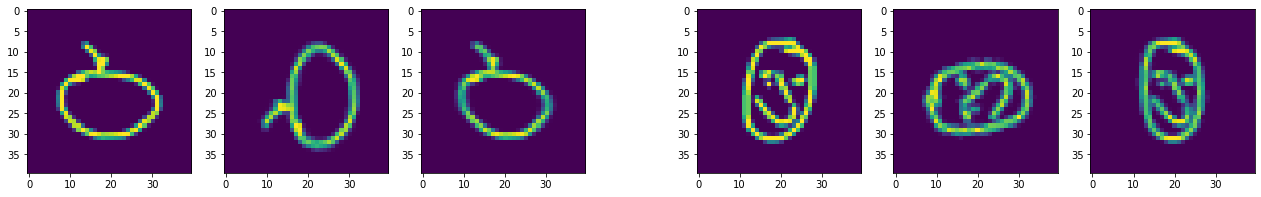

In [15]:
for i in range(0, 10, 2):
    fig = plt.figure()
    fig.set_figheight(22)
    fig.set_figwidth(22)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    gs0 = gridspec.GridSpec(1, 2)

    gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0], hspace=0)
    ax0 = fig.add_subplot(gs00[0])
    ax0.imshow(test_dataset[i][0])
    ax1 = fig.add_subplot(gs00[1], sharex=ax0)
    ax1.imshow(test_dataset_with_rotation[i][0])
    ax2 = fig.add_subplot(gs00[2], sharex=ax0)
    ax2.imshow(test_dataset_with_shearing[i][0])

    gs01 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1], hspace=0)
    ax3 = fig.add_subplot(gs01[0])
    ax3.imshow(test_dataset[i+1][0])
    ax4 = fig.add_subplot(gs01[1], sharex=ax3)
    ax4.imshow(test_dataset_with_rotation[i+1][0])
    ax5 = fig.add_subplot(gs01[2], sharex=ax0)
    ax5.imshow(test_dataset_with_shearing[i+1][0])

# *DataLoader*

In [16]:

train_loader=DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=batch_size,shuffle=False)